In [14]:
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from sklearn.preprocessing import MinMaxScaler
random.seed(42)  # Set a seed value for reproducibility

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

dfDeliveries = pd.read_csv(r"C:\Users\hp\Desktop\MAJOR\Major-CricSim-main\complete_ball_by_ball.csv",low_memory=False) 
dfbatting = pd.read_csv(r"C:\Users\hp\Desktop\MAJOR\Major-CricSim-main\all_bat.csv")
dfbowling = pd.read_csv(r"C:\Users\hp\Desktop\MAJOR\Major-CricSim-main\all_bowl.csv")
dfvenue= pd.read_csv(r"C:\Users\hp\Desktop\MAJOR\Major-CricSim-main\venue.csv")
dfplayervsplayer= pd.read_csv(r"C:\Users\hp\Desktop\MAJOR\Major-CricSim-main\pvp_all.csv")

class Player:
    def __init__(self, name, player_type= None):
        self.name = name
        self.player_type = player_type
    def __str__(self):
        return f"Player Name: {self.name}, Type: {self.player_type}"
class Venue:
    instances = []
    
    def __init__(self, venue_name, matches, total_run, dot_balls, is_wicket_delivery, delivery, fours, sixes, average_score, dot_ball_percentage, average_wickets_fallen, boundary_frequency, dfDeliveries):
        self.venue_name = venue_name
        self.matches = matches
        self.total_run = total_run
        self.dot_balls = dot_balls
        self.is_wicket_delivery = is_wicket_delivery
        self.delivery = delivery
        self.fours = fours
        self.sixes = sixes
        self.average_score = average_score
        self.dot_ball_percentage = dot_ball_percentage
        self.average_wickets_fallen = average_wickets_fallen
        self.boundary_frequency = boundary_frequency
        self.pitch_condition_factor = self.calculate_pitch_factor()  
        self.instances.append(self)
        # Store the DataFrame for deliveries specific to this venue
        self.dfDeliveries = dfDeliveries[dfDeliveries['Venue'] == self.venue_name]

    def calculate_pitch_factor(self):
        return self.average_score / 120

    def calculate_base_probabilities(self, over_number, ball_number=None):
        # Filter for the specific over and (optional) ball number
        if ball_number is not None:
            target_ball = over_number * 6 + ball_number
            filtered_deliveries = self.dfDeliveries[self.dfDeliveries['calculated_ball'] == target_ball]
        else:
            start_ball = over_number * 6
            end_ball = over_number * 6 + 5
            filtered_deliveries = self.dfDeliveries[(self.dfDeliveries['calculated_ball'] >= start_ball) & (self.dfDeliveries['calculated_ball'] <= end_ball)]

        # Calculate probabilities
        outcomes = ['dot', '1', '2', '3', '4', '5', '6', 'wicket']
        counts = {outcome: 0 for outcome in outcomes}
        # Update counts based on the dataframe
        for outcome in outcomes:
            if outcome == 'dot':
                counts[outcome] = len(filtered_deliveries[filtered_deliveries['batsman_run'] == 0]) + len(filtered_deliveries[filtered_deliveries['extras_run'] == 0])
            elif outcome == 'wicket':
                counts[outcome] = len(filtered_deliveries[filtered_deliveries['isWicketDelivery'] == 1])
            else:
                counts[outcome] = len(filtered_deliveries[filtered_deliveries['batsman_run'] == int(outcome)])

        total_counts = sum(counts.values())
        probabilities = {outcome: count / total_counts for outcome, count in counts.items() if total_counts > 0}

        # Adjust if sum of probabilities is not 1 due to rounding
        probability_sum = sum(probabilities.values())
        if probability_sum > 0 and probability_sum != 1:
            probabilities = {outcome: prob / probability_sum for outcome, prob in probabilities.items()}
        
        return probabilities if total_counts > 0 else None

    @classmethod
    def print_all_instances(cls):
        for instance in cls.instances:
            print(f"{instance.venue_name}: Pitch Condition Factor = {instance.pitch_condition_factor}")

# You need to add a calculated_ball column to dfDeliveries before creating Venue instances:
# dfDeliveries['calculated_ball'] = dfDeliveries['overs'] * 6 + dfDeliveries['ballnumber']
def get_venue_features(dfvenue, dfDeliveries, venue_name):
    # Filter the dataframe for the given venue_name
    venue_data = dfvenue[dfvenue['venue_name'] == venue_name].iloc[0]
    
    # Assuming dfDeliveries contains delivery information for all venues,
    # filter it for the current venue
    venue_deliveries = dfDeliveries[dfDeliveries['Venue'] == venue_name]
    
    # Extract features from the filtered dataframe row and create Venue object
    venue = Venue(
        venue_name=venue_data['venue_name'],
        matches=venue_data['Matches'],
        total_run=venue_data['total_run'],
        dot_balls=venue_data['Dot_Balls'],
        is_wicket_delivery=venue_data['isWicketDelivery'],
        delivery=venue_data['delivery'],
        fours=venue_data['Fours'],
        sixes=venue_data['Sixes'],
        average_score=venue_data['Average Score'],
        dot_ball_percentage=venue_data['Dot Ball Percentage'],
        average_wickets_fallen=venue_data['Average Wickets Fallen'],
        boundary_frequency=venue_data['Boundary Frequency'],
        dfDeliveries=venue_deliveries  # Pass the filtered deliveries DataFrame
    )
    
    return venue

class Batsman(Player):
    instances = []
    def __init__(self, name, team,conistency_score=1.0, **kwargs):
        super().__init__(name, "batsman")
        self.team = team  # Include team attribute
        self.active_ratio_death = kwargs.get('Active Ratio_death')
        self.striking_ratio_death = kwargs.get('Striking Ratio_death')
        self.true_sr_death = kwargs.get('True SR_death')
        self.true_avg_death = kwargs.get('True Avg_death')
        self.active_ratio_middle = kwargs.get('Active Ratio_middle')
        self.striking_ratio_middle = kwargs.get('Striking Ratio_middle')
        self.true_sr_middle = kwargs.get('True SR_middle')
        self.true_avg_middle = kwargs.get('True Avg_middle')
        self.active_ratio_powerplay = kwargs.get('Active Ratio_powerplay')
        self.striking_ratio_powerplay = kwargs.get('Striking Ratio_powerplay')
        self.true_sr_powerplay = kwargs.get('True SR_powerplay')
        self.true_avg_powerplay = kwargs.get('True Avg_powerplay')
        self.instances.append(self)
        self.consistency_score = 1
        self.dfDeliveries = dfDeliveries[dfDeliveries['batter'] == self.name].copy()

        
        # Include other attributes...
        self.instances.append(self)
        self.phase_attributes = {
            'powerplay': {},
            'middle': {},
            'death': {}
        }
        for phase in self.phase_attributes:
            for key in kwargs:
                if key.lower().endswith(phase):
                    self.phase_attributes[phase][key] = kwargs[key]
    def calculate_base_probabilities(self, over_number):
    # Calculate the total ball number for easier filtering
        self.dfDeliveries['calculated_ball'] = self.dfDeliveries['overs'] * 6 + self.dfDeliveries['ballnumber']
        
        # Filter for the specific over
        start_ball = over_number * 6
        end_ball = over_number * 6 + 5
        filtered_deliveries = self.dfDeliveries[(self.dfDeliveries['calculated_ball'] >= start_ball) & (self.dfDeliveries['calculated_ball'] <= end_ball)]

        # Calculate probabilities
        outcomes = ['dot', '1', '2', '3', '4', '6', 'wicket']
        counts = {outcome: 0 for outcome in outcomes}

        # Update counts based on the dataframe
        counts['dot'] = len(filtered_deliveries[filtered_deliveries['batsman_run'] == 0])
        counts['wicket'] = len(filtered_deliveries[filtered_deliveries['isWicketDelivery'] == 1])
        for outcome in outcomes:
            if outcome not in ['dot', 'wicket']:
                counts[outcome] = len(filtered_deliveries[filtered_deliveries['batsman_run'] == int(outcome)])

        total_counts = sum(counts.values())
        probabilities = {outcome: count / total_counts for outcome, count in counts.items() if total_counts > 0}

        # Normalize probabilities if the sum is not exactly 1 due to rounding
        probability_sum = sum(probabilities.values())
        if probability_sum > 0 and probability_sum != 1:
            probabilities = {outcome: prob / probability_sum for outcome, prob in probabilities.items()}
        
        return probabilities if total_counts > 0 else None

    def get_phase_modifier(self, phase):
        if phase == 'powerplay':
            attributes = {
                'active_ratio': self.active_ratio_powerplay,
                'striking_ratio': self.striking_ratio_powerplay,
                'true_sr': self.true_sr_powerplay,
                'true_avg': self.true_avg_powerplay
            }
        elif phase == 'middle':
            attributes = {
                'active_ratio': self.active_ratio_middle,
                'striking_ratio': self.striking_ratio_middle,
                'true_sr': self.true_sr_middle,
                'true_avg': self.true_avg_middle
            }
        elif phase == 'death':
            attributes = {
                'active_ratio': self.active_ratio_death,
                'striking_ratio': self.striking_ratio_death,
                'true_sr': self.true_sr_death,
                'true_avg': self.true_avg_death
            }
        else:
            return 1  # Default modifier if phase is not recognized

        # Example calculation, replace with your actual logic
        # This is just a placeholder to demonstrate accessing the attributes
        modifier = sum(attributes.values()) / len(attributes)
        return modifier
        
        

    # Include other methods...

class Bowler(Player):
    instances = []
    def __init__(self, name, team,consistency_score=1.0, **kwargs):
        super().__init__(name, "bowler")
        self.team = team  # Include team attribute
        self.true_economy_death = kwargs.get('True Economy_death')
        self.true_sr_death = kwargs.get('True SR_death')
        self.dot_percentage_death = kwargs.get('dotpercentage_death')
        self.containment_death = kwargs.get('Containment_death')
        self.true_economy_middle = kwargs.get('True Economy_middle')
        self.true_sr_middle = kwargs.get('True SR_middle')
        self.dot_percentage_middle = kwargs.get('dotpercentage_middle')
        self.containment_middle = kwargs.get('Containment_middle')
        self.true_economy_powerplay = kwargs.get('True Economy_powerplay')
        self.true_sr_powerplay = kwargs.get('True SR_powerplay')
        self.dot_percentage_powerplay = kwargs.get('dotpercentage_powerplay')
        self.containment_powerplay = kwargs.get('Containment_powerplay')
        self.instances.append(self)
        self.consistency_score = 1
        self.dfDeliveries = dfDeliveries[dfDeliveries['bowler'] == self.name].copy()

        # Include other attributes...
        self.instances.append(self)
        self.phase_attributes = {
            'powerplay': {},
            'middle': {},
            'death': {}
        }
        for phase in self.phase_attributes:
            for key in kwargs:
                if key.lower().endswith(phase):
                    self.phase_attributes[phase][key] = kwargs[key]
    def get_phase_modifier(self, phase):
        if phase == 'powerplay':
            attributes = {
                'active_ratio': self.active_ratio_powerplay,
                'striking_ratio': self.striking_ratio_powerplay,
                'true_sr': self.true_sr_powerplay,
                'true_avg': self.true_avg_powerplay
            }
        elif phase == 'middle':
            attributes = {
                'active_ratio': self.active_ratio_middle,
                'striking_ratio': self.striking_ratio_middle,
                'true_sr': self.true_sr_middle,
                'true_avg': self.true_avg_middle
            }
        elif phase == 'death':
            attributes = {
                'active_ratio': self.active_ratio_death,
                'striking_ratio': self.striking_ratio_death,
                'true_sr': self.true_sr_death,
                'true_avg': self.true_avg_death
            }
        else:
            return 1  # Default modifier if phase is not recognized

        # Example calculation, replace with your actual logic
        # This is just a placeholder to demonstrate accessing the attributes
        modifier = sum(attributes.values()) / len(attributes)
        return modifier
    def calculate_base_probabilities(self, over_number):
        # Ensure 'calculated_ball' column exists or create it
        if 'calculated_ball' not in self.dfDeliveries.columns:
            self.dfDeliveries['calculated_ball'] = self.dfDeliveries['overs'] * 6 + self.dfDeliveries['ballnumber']
        
        # Filter for the specific over
        start_ball = over_number * 6
        end_ball = over_number * 6 + 5
        filtered_deliveries = self.dfDeliveries[(self.dfDeliveries['calculated_ball'] >= start_ball) & (self.dfDeliveries['calculated_ball'] <= end_ball)]

        # Calculate probabilities for outcomes
        outcomes = ['dot', '1', '2', '3', '4', '6', 'wicket']
        counts = {outcome: 0 for outcome in outcomes}

        counts['dot'] = len(filtered_deliveries[filtered_deliveries['batsman_run'] == 0])
        counts['wicket'] = len(filtered_deliveries[filtered_deliveries['isWicketDelivery'] == 1])
        for outcome in outcomes:
            if outcome not in ['dot', 'wicket']:
                counts[outcome] = len(filtered_deliveries[filtered_deliveries['batsman_run'] == int(outcome)])

        total_counts = sum(counts.values())
        probabilities = {outcome: count / total_counts for outcome, count in counts.items() if total_counts > 0}

        # Normalize probabilities to ensure their sum equals 1
        probability_sum = sum(probabilities.values())
        if probability_sum > 0 and probability_sum != 1:
            probabilities = {outcome: prob / probability_sum for outcome, prob in probabilities.items()}
        
        return probabilities if total_counts > 0 else None

        
    # Include other methods...

def get_player_all_profiles(playing_xi_team, dfbatting, dfbowling):
    # Initialize empty dicts to hold player profiles
    player_profiles = {}
    
    # Search and Extract Profiles for Both Batting and Bowling
    for team, player_list in playing_xi_team.items():
        for player in player_list:
            player_profiles[player] = {
                'batting': None,
                'bowling': None
            }

            # Check batting stats
            if player in dfbatting['batter'].values:
                player_profiles[player]['batting'] = dfbatting[dfbatting['batter'] == player].to_dict('records')[0]

            # Check bowling stats
            if player in dfbowling['bowler'].values:
                player_profiles[player]['bowling'] = dfbowling[dfbowling['bowler'] == player].to_dict('records')[0]

    return player_profiles
dfDeliveries['calculated_ball'] = dfDeliveries['overs'] * 6 + dfDeliveries['ballnumber']


In [15]:
numerical_cols_dfbatting = dfbatting.select_dtypes(include=['float64', 'int64']).columns
numerical_cols_dfbowling = dfbowling.select_dtypes(include=['float64', 'int64']).columns

# Normalize dfbatting
scaler = MinMaxScaler(feature_range=(-1, 1))
dfbatting[numerical_cols_dfbatting] = scaler.fit_transform(dfbatting[numerical_cols_dfbatting])

# Normalize dfbowling
dfbowling[numerical_cols_dfbowling] = scaler.fit_transform(dfbowling[numerical_cols_dfbowling])


In [16]:
def select_bowler(bowlers, phase):
    weights = {
        'Powerplay': {
            'true_economy_powerplay': 0.3,  # Higher is better
            'true_sr_powerplay': 0.25,  # Higher is better
            'dot_percentage_powerplay': 0.25,  # Higher is better
            'containment_powerplay': 0.2,  # Higher is better
        },
        'Middle Overs': {
            'true_economy_middle': 0.25,  # Higher is better
            'true_sr_middle': 0.3,  # Higher is better
            'dot_percentage_middle': 0.2,  # Higher is better
            'containment_middle': 0.25,  # Higher is better
        },
        'Death Overs': {
            'true_economy_death': 0.2,  # Higher is better
            'true_sr_death': 0.3,  # Higher is better
            'dot_percentage_death': 0.3,  # Higher is better
            'containment_death': 0.2,  # Higher is better
        }
    }
    
    phase_weights = weights[phase]
    
    def bowler_score(bowler):
        score = 0
        for attr, weight in phase_weights.items():
            stat = getattr(bowler, attr, 0)
            score += stat * weight  # Higher stats contribute more positively
        return score
    
    best_bowler = max(bowlers, key=bowler_score)
    return best_bowler


In [17]:
def select_batsman(batsmen, phase):
    weights = {
        'Powerplay': {
            'active_ratio_powerplay': 0.1,
            'striking_ratio_powerplay': 0.2,
            'true_sr_powerplay': 0.4,
            'true_avg_powerplay': 0.3,
        },
        'Middle Overs': {
            'active_ratio_middle': 0.15,
            'striking_ratio_middle': 0.15,
            'true_sr_middle': 0.35,
            'true_avg_middle': 0.35,
        },
        'Death Overs': {
            'active_ratio_death': 0.2,
            'striking_ratio_death': 0.25,
            'true_sr_death': 0.3,
            'true_avg_death': 0.25,
        }
    }
    
    phase_weights = weights[phase]
    
    def batsman_score(batsman):
        score = 0
        for attr, weight in phase_weights.items():
            stat = getattr(batsman, attr, 0)
            score += weight * stat
        return score
    
    best_batsman = max(batsmen, key=batsman_score)
    return best_batsman


In [18]:

def simulate_match(team1, team2, venue):
    # Correct variable names used for team rosters
    team1_batsmen = batsmen1
    team1_bowlers = bowlers1
    team2_batsmen = batsmen2
    team2_bowlers = bowlers2

    # Simulate the first innings
    team1_runs, team1_wickets, team1_ball_data = simulate_innings(team1_batsmen, team2_bowlers, venue, 1)
    print(f"Team 1 scored {team1_runs} for {team1_wickets} wickets.")

    # Simulate the second innings with an additional check for surpassing Team 1's score
    team2_runs, team2_wickets, team2_ball_data = simulate_innings(team2_batsmen, team1_bowlers, venue, 2, is_second_innings=True, target_runs=team1_runs + 1)
    print(f"Team 2 scored {team2_runs} for {team2_wickets} wickets.")

    # Determine the winner based on the scores
    if team1_runs > team2_runs:
        print(f"Team 1 wins by {team1_runs - team2_runs} runs.")
    elif team2_runs > team1_runs:
        print(f"Team 2 wins with {10 - team2_wickets} wickets remaining.")
    else:
        print("The match is a tie.")

    # Combine ball data from both innings and create DataFrame
    all_balls_data = team1_ball_data + team2_ball_data
    match_df = pd.DataFrame(all_balls_data)

    # This line is for demonstration. You may want to return, save, or process the DataFrame differently.
    return match_df

def print_ball_outcome(outcome_description):
    print(outcome_description)



In [19]:
def adjust_probabilities(base_probabilities, batting_modifier, bowling_modifier):
    # Example of a more subtle adjustment
    adjusted_probabilities = {}
    for outcome, base_prob in base_probabilities.items():
        adjusted_prob = base_prob * (1 + 0.5 * (batting_modifier - bowling_modifier))
        adjusted_probabilities[outcome] = max(min(adjusted_prob, 0.9), 0.1)  # Ensure probabilities are within realistic bounds

    # Normalize probabilities
    total_prob = sum(adjusted_probabilities.values())
    adjusted_probabilities = {outcome: prob / total_prob for outcome, prob in adjusted_probabilities.items()}
    
    return adjusted_probabilities


In [20]:
def simulate_innings(batsmen, bowlers, venue, innings, total_overs=20, is_second_innings=False, target_runs=None):
    runs = 0
    wickets = 0
    all_balls_data = []
    last_bowler = None
    bowler_overs = {bowler.name: 0 for bowler in bowlers}

    # Initialize on-field and available batsmen
    on_field_batsmen = [batsmen[0], batsmen[1]]  # Start with the first two chosen batsmen
    available_batsmen = batsmen[2:]  # The rest are waiting

    striker_index = 0

    for over in range(total_overs):
        phase = "Powerplay" if over < 6 else "Middle Overs" if 6 <= over < 15 else "Death Overs"
        
        # Select the best bowler for the current phase
        current_bowler = select_bowler([b for b in bowlers if b.name != last_bowler and bowler_overs[b.name] < 4], phase)
        last_bowler = current_bowler.name
        bowler_overs[current_bowler.name] += 1

        for ball in range(1, 7):  # Each over consists of 6 legal deliveries
            if wickets >= 10 or (is_second_innings and runs >= target_runs):
                break  # All out or target achieved
            
            striker = on_field_batsmen[striker_index]
            
            ball_data, outcome_description = simulate_ball(striker, current_bowler, over, venue)
            all_balls_data.append(ball_data)
            
            runs += ball_data['batsman_run']
            wickets += ball_data['isWicketDelivery']
            
            if ball_data['isWicketDelivery']:
                if available_batsmen:
                    # Select the best available batsman after the fall of a wicket
                    best_next_batsman = select_batsman(available_batsmen, phase)
                    on_field_batsmen[striker_index] = best_next_batsman
                    available_batsmen.remove(best_next_batsman)
                else:
                    break  # No more batsmen to bat
            
            if ball_data['batsman_run'] % 2 != 0:
                striker_index = 1 - striker_index
        
        if ball == 6:  # Switch the strike at the end of the over
            striker_index = 1 - striker_index

    return runs, wickets, all_balls_data


In [31]:
import numpy as np
random.seed(42)  # Set a seed value for reproducibility

def simulate_ball(batsman, bowler, over_number, venue):
    over_number = int(over_number)
    venue_probs = venue.calculate_base_probabilities(over_number)
    batsman_probs = batsman.calculate_base_probabilities(over_number) or {}
    bowler_probs = bowler.calculate_base_probabilities(over_number) or {}

    combined_probabilities = {}
    for outcome in venue_probs.keys():
        venue_prob = venue_probs.get(outcome, 0)
        batsman_prob = batsman_probs.get(outcome, 0)
        bowler_prob = bowler_probs.get(outcome, 0)
        
        # Calculating weighted probabilities
        combined_prob = 0.5 * venue_prob + 0.25 * batsman_prob - 0.25 * bowler_prob
        combined_probabilities[outcome] = np.clip(combined_prob, 0, 1)
    
    # Normalize the combined probabilities to ensure they sum to 1
    total_prob = sum(combined_probabilities.values())
    normalized_probabilities = {outcome: (prob / total_prob) for outcome, prob in combined_probabilities.items() if total_prob > 0}
    
    # Ensure we have normalized probabilities; if total_prob is 0, it implies an error in calculation or data
    if not normalized_probabilities:
        raise ValueError("Combined probabilities normalization failed due to zero total probability. Check input data and calculations.")

    # Select outcome based on normalized probabilities
    outcomes, probabilities = zip(*normalized_probabilities.items())
    outcome = np.random.choice(outcomes, p=probabilities)
    print(outcome, probabilities)
    
    # Generate ball outcome data based on the selected outcome
    ball_data = {
        'batter': batsman.name,
        'bowler': bowler.name,
        'batsman_run': int(outcome) if outcome.isdigit() else 0,
        'extras_run': 0,
        'total_run': int(outcome) if outcome.isdigit() else 0,
        'non_boundary': 0 if outcome in ['4', '6'] else 1,
        'isWicketDelivery': 1 if outcome == 'wicket' else 0,
        'player_out': batsman.name if outcome == 'wicket' else '',
        'BattingTeam': batsman.team,
        'Venue': venue.venue_name,
        'BowlingTeam': bowler.team
    }

    outcome_description = f"{batsman.name} scores {outcome} run(s) against {bowler.name}" if outcome.isdigit() else f"{batsman.name} is out" if outcome == 'wicket' else f"{batsman.name} faces a dot ball against {bowler.name}"

    return ball_data, outcome_description


In [33]:
team1 = {
    'team_name': ["A Symonds", "AC Gilchrist","SR Watson","AD Russell","BA Stokes","CH Gayle","CH Morris","JC Archer","KA Pollard","KP Pietersen","Shakib Al Hasan"]
}
team2 = {
    'team_name': ["SR Tendulkar", "Z Khan","RG Sharma","V Kohli","MS Dhoni","KH Pandya","HH Pandya","JJ Bumrah","SK Raina","YK Pathan","YS Chahal"]
}
batsmen1 = []
bowlers1 = []
batsmen2 = []
bowlers2 = []
player_stats1 = get_player_all_profiles(team1,  dfbatting, dfbowling)
player_stats2 = get_player_all_profiles(team2,  dfbatting, dfbowling)
for player_name, stats in player_stats1.items():
    if 'batting' in stats and stats['batting'] is not None:
        batsmen1.append(Batsman(player_name, team="Team 1", **stats['batting']))
    if 'bowling' in stats and stats['bowling'] is not None:
        bowlers1.append(Bowler(player_name, team="Team 1", **stats['bowling']))

for player_name, stats in player_stats2.items():
    if 'batting' in stats and stats['batting'] is not None:
        batsmen2.append(Batsman(player_name, team="Team 2", **stats['batting']))
    if 'bowling' in stats and stats['bowling'] is not None:
        bowlers2.append(Bowler(player_name, team="Team 2", **stats['bowling']))



venue_name = "Brabourne Stadium"
venue1 = get_venue_features(dfvenue, dfDeliveries, venue_name)
# Create combined lists for batsmen and bowlers from both teams
all_batsmen = batsmen1 + batsmen2
all_bowlers = bowlers1 + bowlers2

# Now call simulate_match with the combined lists
df1=simulate_match(team1, team2, venue1)
#simulate_match(team1,team2,venue1)
#df1


dot (0.6666666666666666, 0.06666666666666667, 0.10000000000000002, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0)
dot (0.6666666666666666, 0.06666666666666667, 0.10000000000000002, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0)
dot (0.6666666666666666, 0.06666666666666667, 0.10000000000000002, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0)
2 (0.6666666666666666, 0.06666666666666667, 0.10000000000000002, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0)
2 (0.6666666666666666, 0.06666666666666667, 0.10000000000000002, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0)
dot (0.6666666666666666, 0.06666666666666667, 0.10000000000000002, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0)
dot (0.5714285714285714, 0.19999999999999998, 0.0, 0.0, 0.0, 0.0, 0.22857142857142856, 0.0)
dot (0.5714285714285714, 0.19999999999999998, 0.0, 0.0, 0.0, 0.0, 0.22857142857142856, 0.0)
dot (0.5714285714285714, 0.19999999999999998, 0.0, 0.0, 0.0, 0.0, 0.22857142857142856, 0.0)
6 (0.5714285714285714, 0.19999999999999998, 0.0, 0.0, 0.0, 0.0, 0.22857142857142

In [35]:
df1

,batter,bowler,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,BattingTeam,Venue,BowlingTeam,cumulative_runs,ball_number
0,A Symonds,JJ Bumrah,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,0,1
1,A Symonds,JJ Bumrah,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,0,2
2,A Symonds,JJ Bumrah,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,0,3
3,A Symonds,JJ Bumrah,2,0,2,1,0,,Team 1,Brabourne Stadium,Team 2,2,4
4,A Symonds,JJ Bumrah,2,0,2,1,0,,Team 1,Brabourne Stadium,Team 2,4,5
5,A Symonds,JJ Bumrah,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,4,6
6,AC Gilchrist,Z Khan,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,4,7
7,AC Gilchrist,Z Khan,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,4,8
8,AC Gilchrist,Z Khan,0,0,0,1,0,,Team 1,Brabourne Stadium,Team 2,4,9
9,AC Gilchrist,Z Khan,6,0,6,0,0,,Team 1,Brabourne Stadium,Team 2,10,10


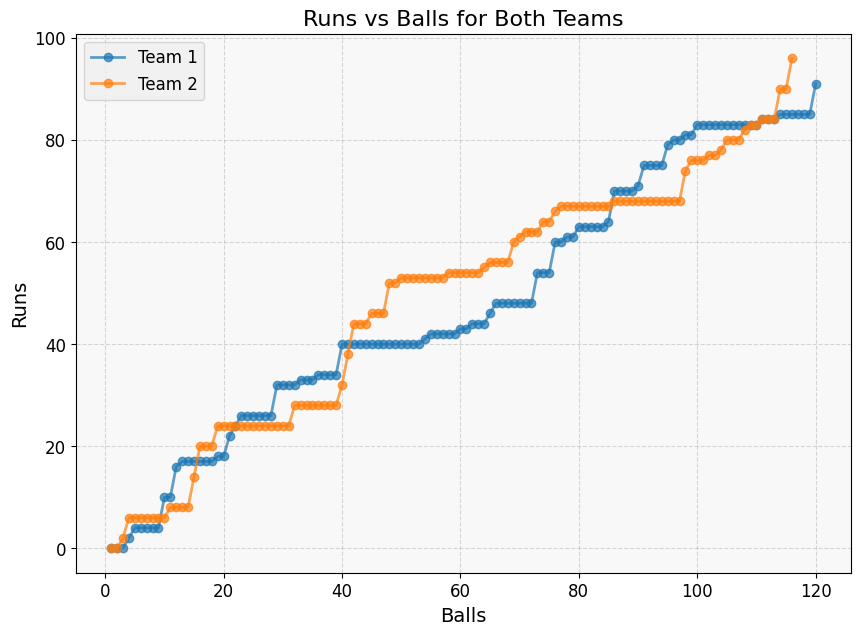

In [34]:
# Calculate cumulative runs for each team
df=df1
df['cumulative_runs'] = df.groupby('BattingTeam')['batsman_run'].cumsum()

# Calculate ball count for each team (assuming each row is a ball played)
df['ball_number'] = df.groupby('BattingTeam').cumcount() + 1

df_sorted = df 
# Prepare the data as before...

# Adjust figsize here for the desired plot dimensions
fig, ax = plt.subplots(figsize=(10, 7))

# Define your color palette here
colors = ['#1f77b4', '#ff7f0e']

for (team, group), color in zip(df_sorted.groupby('BattingTeam'), colors):
    # Increase the linewidth for better visibility
    ax.plot(group['ball_number'], group['cumulative_runs'], label=team, 
            marker='o', linestyle='-', linewidth=2, markersize=6, alpha=0.7, color=color)

# Set larger font sizes
plt.rcParams.update({'font.size': 12})

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Add axis labels and title with increased font size
ax.set_xlabel('Balls', fontsize=14)
ax.set_ylabel('Runs', fontsize=14)
ax.set_title('Runs vs Balls for Both Teams', fontsize=16)

# Set axis limits if needed (uncomment to set specific limits)
# ax.set_xlim([0, max_balls])
# ax.set_ylim([0, max_runs])

# Add background color
ax.set_facecolor('#f8f8f8')  # A light grey background color

# Make legend more legible
ax.legend(fontsize=12, frameon=True, facecolor='#f0f0f0')

plt.show()
 